In [1]:
import os
import sys

import numpy as np
import cv2
from sklearn import linear_model

from lane_ransac import LaneRANSACRegressor

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
def calibration_parameters(path, cshape):
    """Compute calibration parameters from a set of calibration images.
    
    Params:
      path: Directory of calibration images.
      cshape: Shape of grid used in the latter.
    Return:
      mtx, dist
    """
    # Object / image points collections.
    objpoints = []
    imgpoints = []

    # Calibration points from images.
    filenames = os.listdir(path)
    for fname in filenames:
        img = cv2.imread(path + fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Theoretical Grid.
        objp = np.zeros((cshape[0] * cshape[1], 3), np.float32)
        objp[:, :2] = np.mgrid[0:cshape[0], 0:cshape[1]].T.reshape(-1, 2)
        # Corners in the image.
        ret, corners = cv2.findChessboardCorners(gray, cshape, None)
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
        else:
            print('Warning! Not chessboard found in the image', fname)
    
    # Calibration from image points.
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    return mtx, dist

In [4]:
# Calibration parameters.
cshape = (9, 6)
path = 'camera_cal/'
mtx, dist = calibration_parameters(path, cshape)

Warning! Not chessboard found in the image calibration1.jpg
Warning! Not chessboard found in the image calibration4.jpg
Warning! Not chessboard found in the image calibration5.jpg


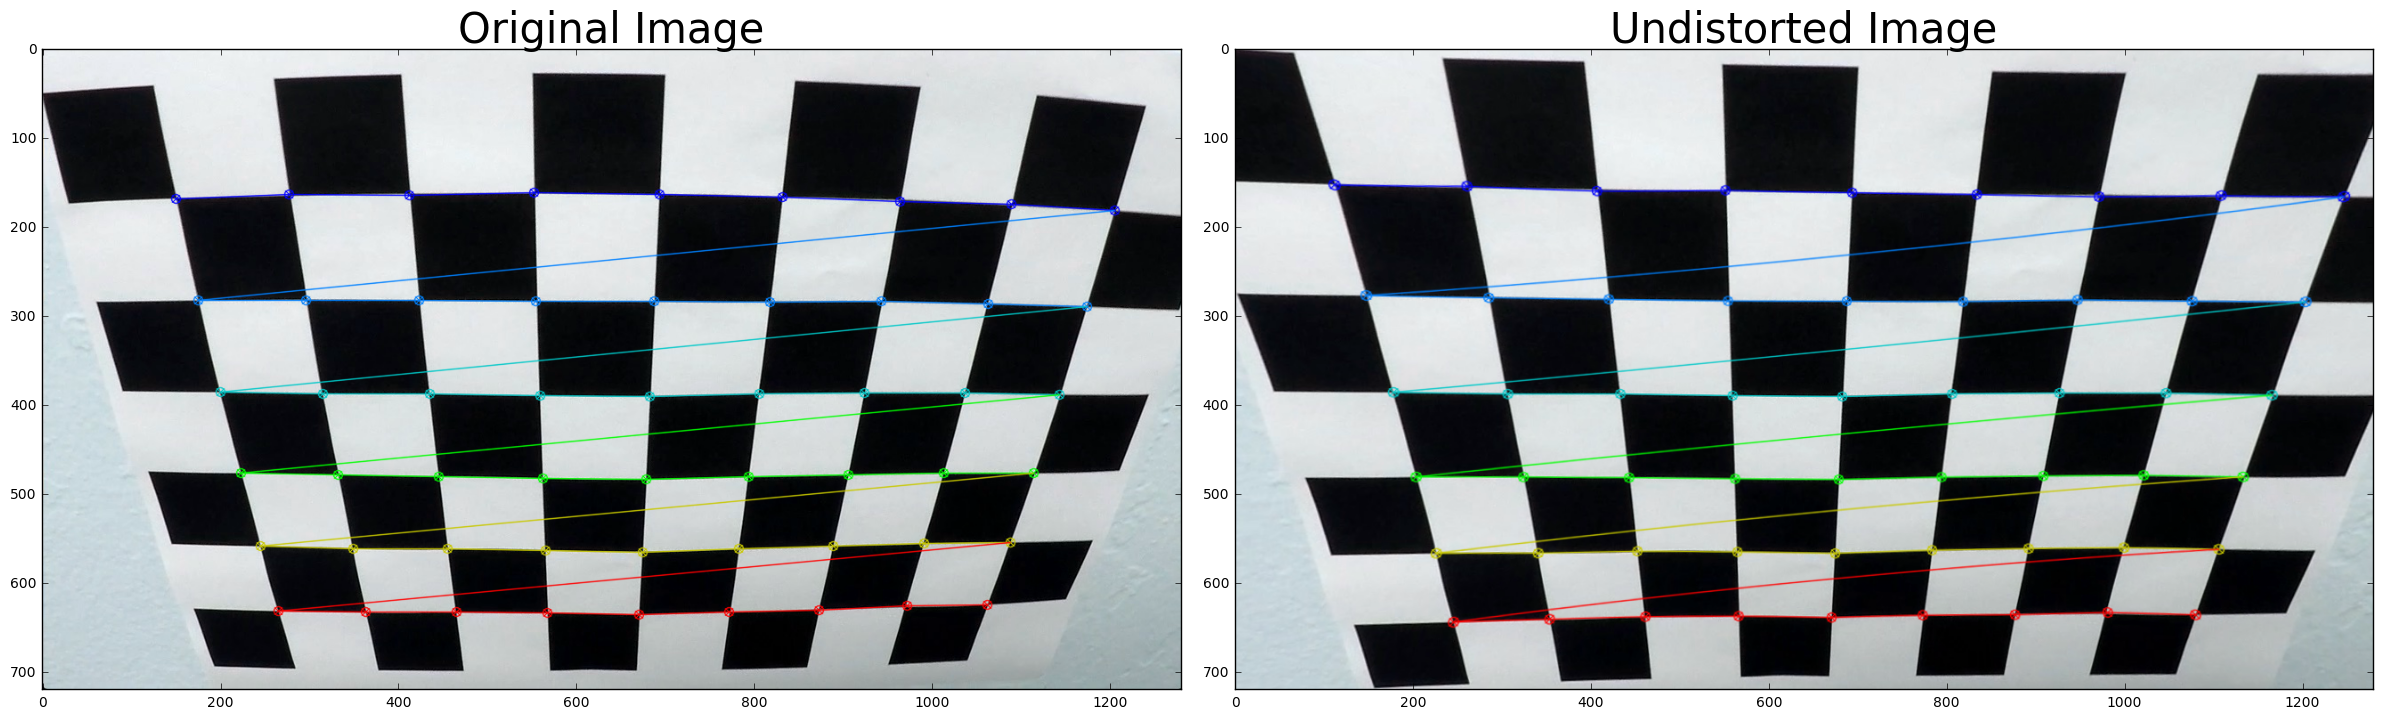

In [5]:
# Test the calibration on some image.
filenames = os.listdir(path)
img = cv2.imread(path + filenames[11])
ret, corners = cv2.findChessboardCorners(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cshape, None)
img = cv2.drawChessboardCorners(img, cshape, corners, ret)
undst = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undst)
ax2.set_title('Undistorted Image', fontsize=30)

In [6]:
def load_image(filename, crop_shape=(720, 1280)):
    """Load an image, and crop it to the correct shape if necessary.
    """
    img = mpimg.imread(filename)
    shape = img.shape
    # Cropping.
    if shape[0] > crop_shape[0]:
        img = img[-crop_shape[0]:, :, :]
    if shape[1] > crop_shape[1]:
        img = img[:, :crop_shape[1], :]
    return img

In [7]:
def gradient_magnitude(gray, sobel_kernel=3):
    """Compute mask based on gradient magnitude. Input image assumed
    to be two dimensional.
    """
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Norm and rescaling (c.f. different kernel sizes)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag) / 255.
    gradmag = (gradmag / scale_factor)
    return gradmag

def gradient_x(gray, sobel_kernel=3):
    """Compute mask based on horizontal gradient. Input image assumed
    to be two dimensional.
    """
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    gradmag = sobelx
    scale_factor = np.max(gradmag) / 255.
    gradmag = (gradmag / scale_factor)
    return gradmag

def mask_local_crossing_x(gray, threshold=20, dilate_kernel=(2, 6), iterations=3):
    # Increasing mask.
    mask_neg = (gray < -threshold).astype(np.float32)
    mask_pos = (gray > threshold).astype(np.float32)
    
#     iterations=4
    mid=dilate_kernel[1] // 2
    # Dilate mask to the left.
    kernel = np.ones(dilate_kernel, np.uint8)
    kernel[:, 0:mid] = 0
    dmask_neg = cv2.dilate(mask_neg, kernel, iterations=iterations) > 0.
    # Dilate mask to the right.
    kernel = np.ones(dilate_kernel, np.uint8)
    kernel[:, mid:] = 0
    dmask_pos = cv2.dilate(mask_pos, kernel, iterations=iterations) > 0.
    dmask = (dmask_pos * dmask_neg).astype(np.uint8)
    
    # Eroding a bit
#     kernel = np.ones((1,2),np.uint8)
#     dmask = cv2.erode(dmask, kernel, iterations=5)
    return dmask
    

def mask_threshold(gray, threshold=(0, 255)):
    mask = np.zeros_like(gray)
    mask[(gray >= threshold[0]) & (gray <= threshold[1])] = 1
    return mask


def color_threshold(gray, threshold=(0, 255)):
    mask = np.zeros_like(gray)
    mask[(gray >= threshold[0]) & (gray <= threshold[1])] = 1
    return mask

In [8]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """Draw a collection of lines on an image.
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def draw_mask(img, mask, color=[255, 0, 0], α=0.8, β=1., λ=0.):
    """The result image is computed as follows: img * α + mask * β + λ
    where mask is transformed into an RGB image.
    """
    mask = (mask > 0).astype(np.uint8)
    color_mask = np.dstack((color[0] * mask, color[1] * mask, color[2] * mask))
    return cv2.addWeighted(img, α, color_mask, β, λ)

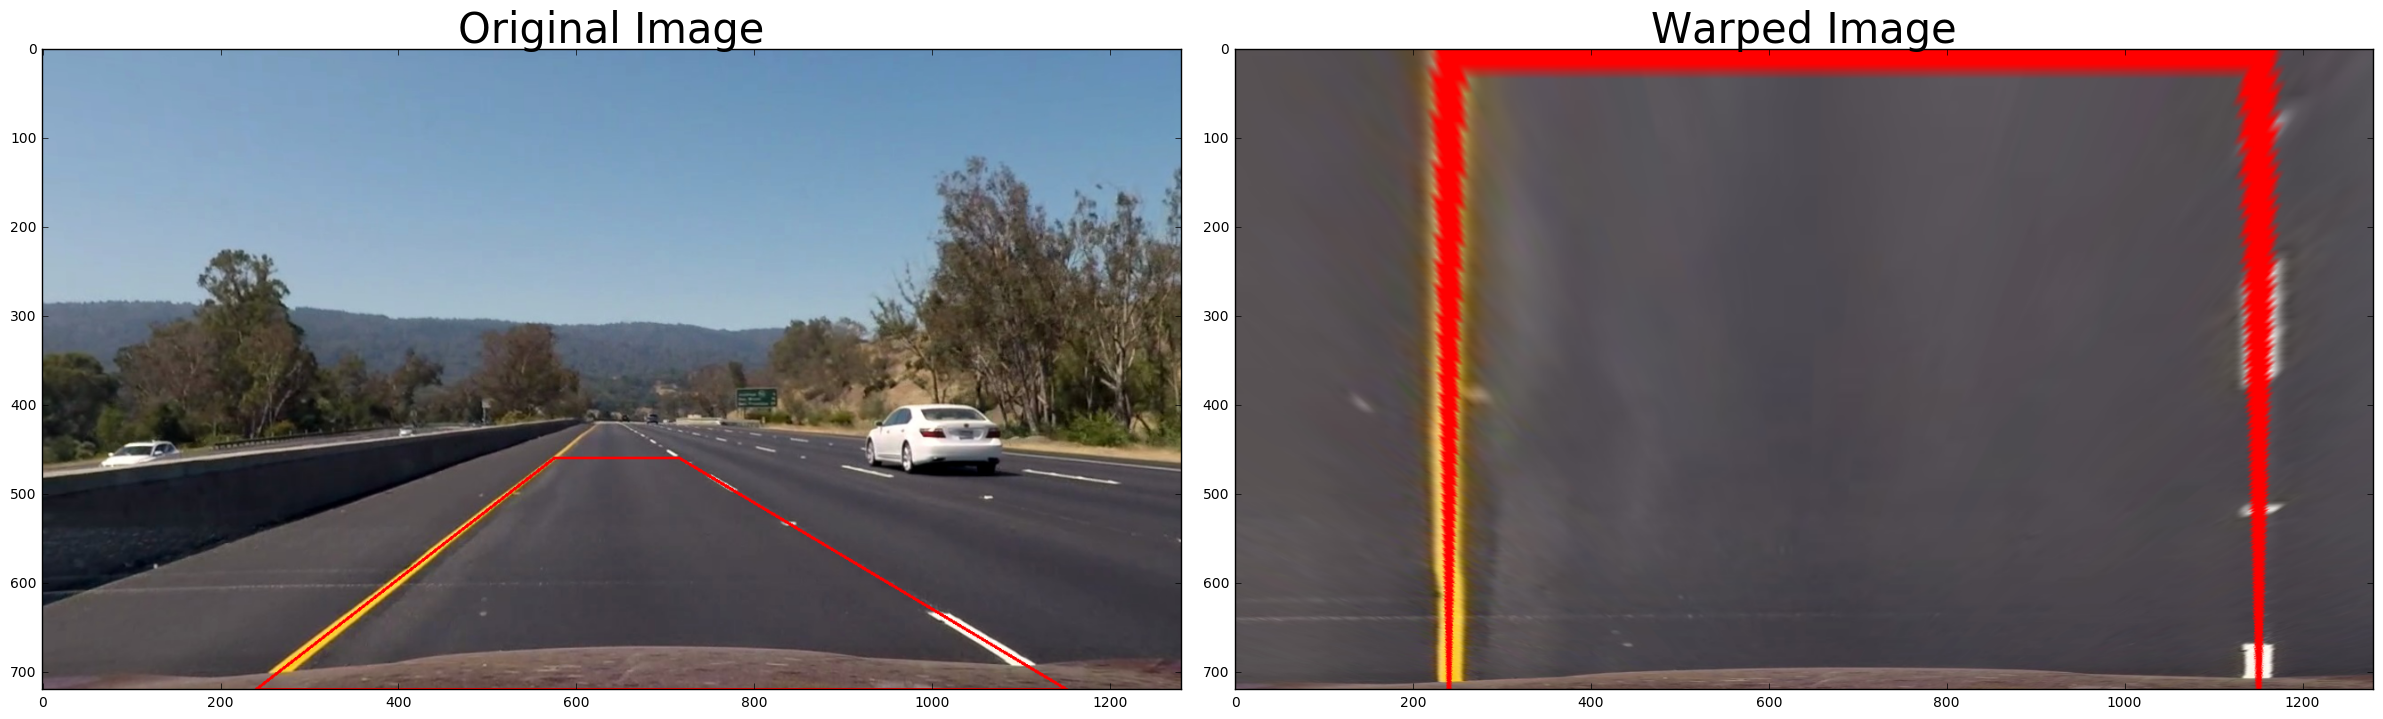

In [9]:
# Reference image for perspective transform.
filename = 'test_images/perspective.jpg'
img = load_image(filename)
img = cv2.undistort(img, mtx, dist, None, mtx)
img_size = (img.shape[1], img.shape[0])

# Source points for perspective transform.
src_points = [[240, 720],
              [575, 460],
              [715, 460],
              [1150, 720]]
src_points = np.array(src_points, dtype=np.float32)
# Destination points: keep same image size.
dst_points = [[240, 720],
              [240, 0],
              [1150, 0],
              [1150, 720]]
dst_points = np.array(dst_points, dtype=np.float32)

# Perspective transform (and inverse)
m_perp = cv2.getPerspectiveTransform(src_points, dst_points)
m_inv_perp = cv2.getPerspectiveTransform(dst_points, src_points)

# Print lines!
l = len(src_points)
lines = [ [[src_points[i][0], src_points[i][1], src_points[(i+1)%l][0], src_points[(i+1)%l][1]]] for i in range(l)]
draw_lines(img, lines, thickness=2)

# Apply transform.
wimg = cv2.warpPerspective(img, m_perp, img_size, flags=cv2.INTER_LINEAR)
unwimg = cv2.warpPerspective(wimg, m_inv_perp, img_size, flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(wimg)
ax2.set_title('Warped Image', fontsize=30)
plt.show()

In [10]:
# Test images.
path = 'test_images/'
filenames = os.listdir(path)
print(filenames)

['perspective.jpg', 'signs_vehicles_xygrad.jpg', 'test (1).jpg', 'test (10).jpg', 'test (11).jpg', 'test (12).jpg', 'test (13).jpg', 'test (14).jpg', 'test (15).jpg', 'test (16).jpg', 'test (17).jpg', 'test (18).jpg', 'test (19).jpg', 'test (2).jpg', 'test (3).jpg', 'test (4).jpg', 'test (5).jpg', 'test (6).jpg', 'test (7).jpg', 'test (8).jpg', 'test (9).jpg', 'test1.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']


test_images/test (2).jpg (720, 1280, 3)


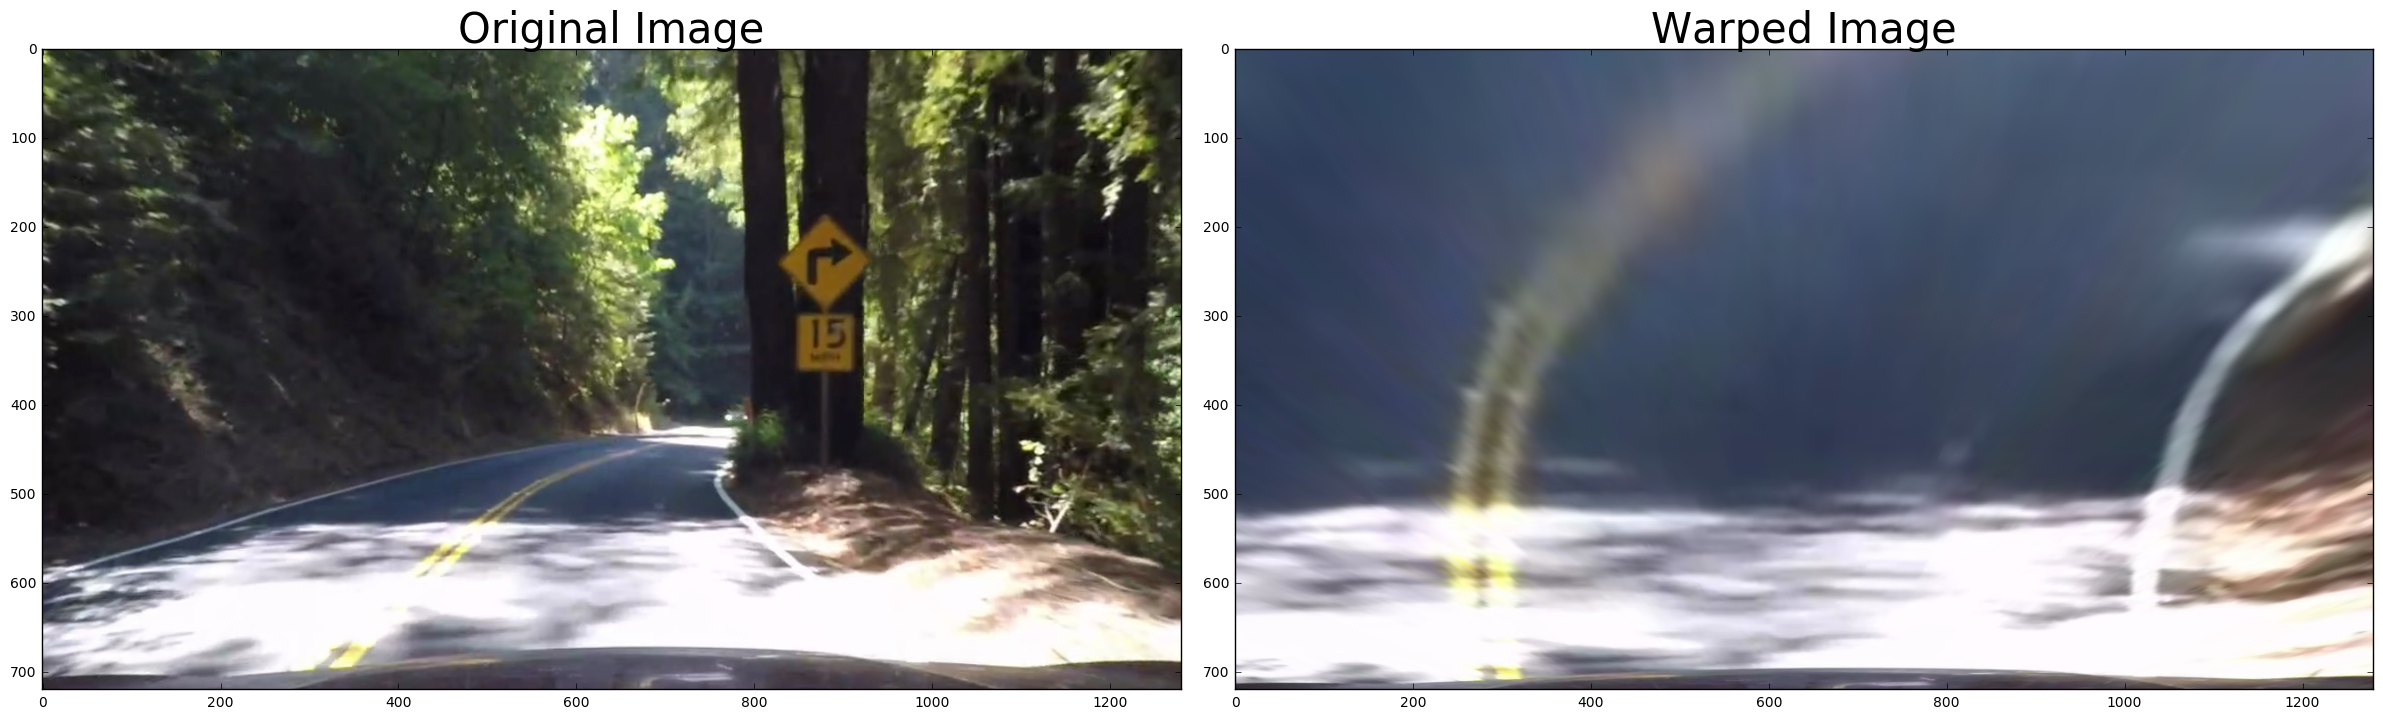

In [11]:
# Test on some image...
filename = path + os.listdir(path)[13]
img = load_image(filename)
img = cv2.undistort(img, mtx, dist, None, mtx)
print(filename, img.shape)
undst = img

# Warped image.
wimg = cv2.warpPerspective(img, m_perp, img_size, flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(wimg)
ax2.set_title('Warped Image', fontsize=30)
plt.show()

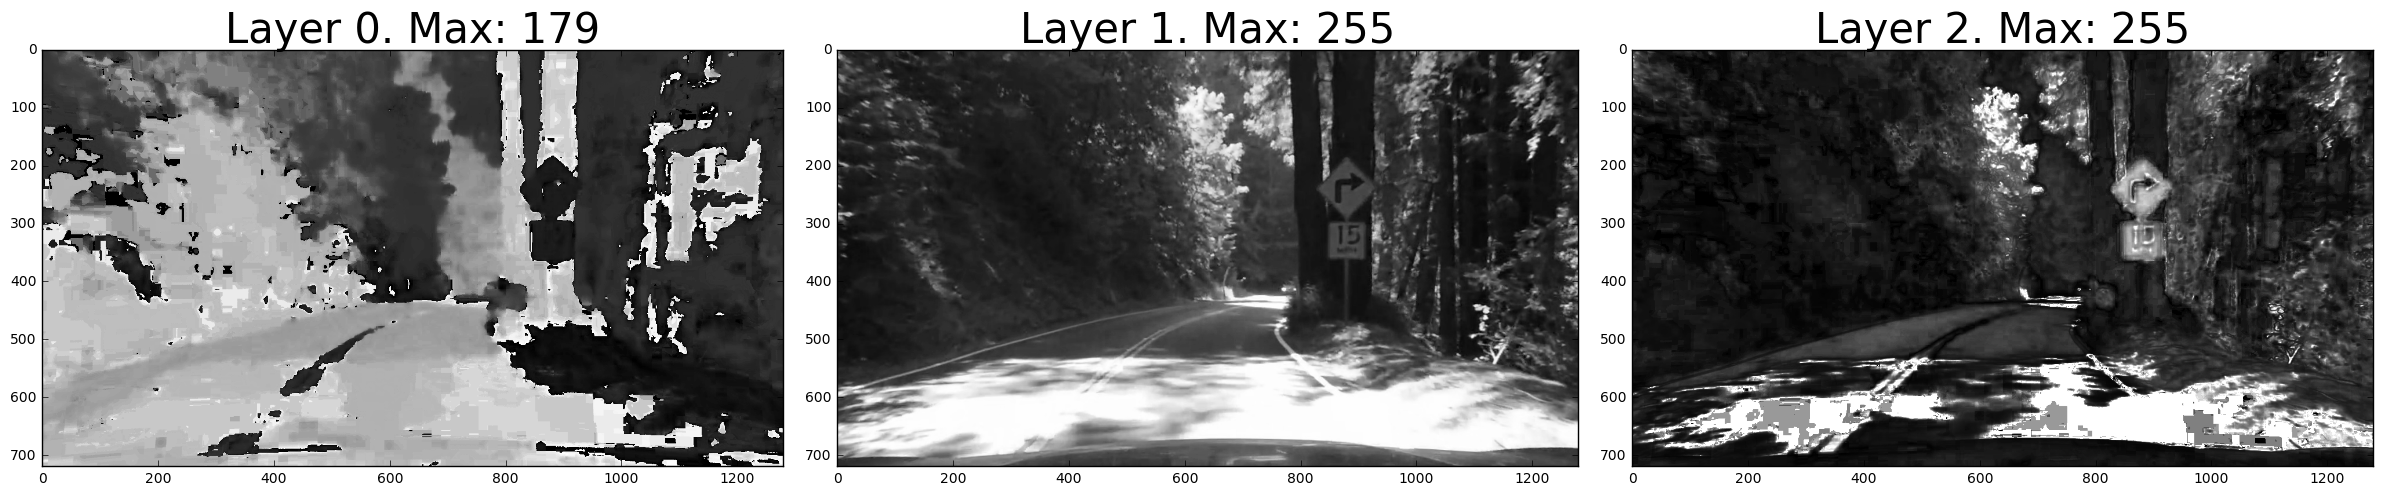

In [12]:
ungray = cv2.cvtColor(undst, cv2.COLOR_RGB2GRAY)
unhsl = cv2.cvtColor(undst, cv2.COLOR_RGB2HLS)
# unhsl = cv2.cvtColor(undst, cv2.COLOR_RGB2YUV)

f, axes = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
for i in range(3):
    axes[i].imshow(unhsl[:, :, i], cmap='gray')
    axes[i].set_title('Layer %i. Max: %i' % (i, np.max(unhsl[:, :, i])), fontsize=30)
plt.show()



In [13]:
def warped_masks(img, m_perp):
    """Generate a collection of masks for lines.
    Note: a collection can be useful to then compute weights.
    """
    # Grayscale and HSL.
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Compute x gradients.
    skernel = -1
    sobel_dx = gradient_x(gray, sobel_kernel=skernel)
    s_sobel_dx = gradient_x(hsl[:, :, 2], sobel_kernel=skernel)
    # sobel_mag = gradient_magnitude(ungray, sobel_kernel=5)
    
    # Warped gradient fields.
    wsobel_dx = cv2.warpPerspective(sobel_dx, m_perp, img_size, flags=cv2.INTER_LANCZOS4)
    ws_sobel_dx = cv2.warpPerspective(s_sobel_dx, m_perp, img_size, flags=cv2.INTER_LANCZOS4)

    # Construct warped masks
    wmasks = []
    wmasks.append(mask_local_crossing_x(wsobel_dx, threshold=20, dilate_kernel=(1, 8), iterations=4))
    wmasks.append(mask_local_crossing_x(ws_sobel_dx, threshold=20, dilate_kernel=(1, 8), iterations=4))

    # masks.append(mask_threshold(sobel_mag, threshold=(50, 255)))
    # masks.append(mask_threshold(s_sobel_mag, threshold=(30, 255)))
    # masks.append(color_threshold(unhsl[:, :, 2], threshold=(10, 255)))
    # masks.append(color_threshold(unhsl[:, :, 2], threshold=(10, 255)))
    
    return wmasks

def default_left_right_masks(img, margin=0.1):
    """Default left and right masks used to find lanes: middle split with some additional margin.
    """
    shape = img.shape[0:2]
    llimit = int(shape[1] / 2 + shape[1] * margin)
    rlimit = int(shape[1] / 2 - shape[1] * margin)
    
    # Mask from meshgrid.
    xv, yv = np.mgrid[0:shape[0], 0:shape[1]]
    lmask = yv <= llimit
    rmask = yv >= rlimit
    
    return lmask, rmask


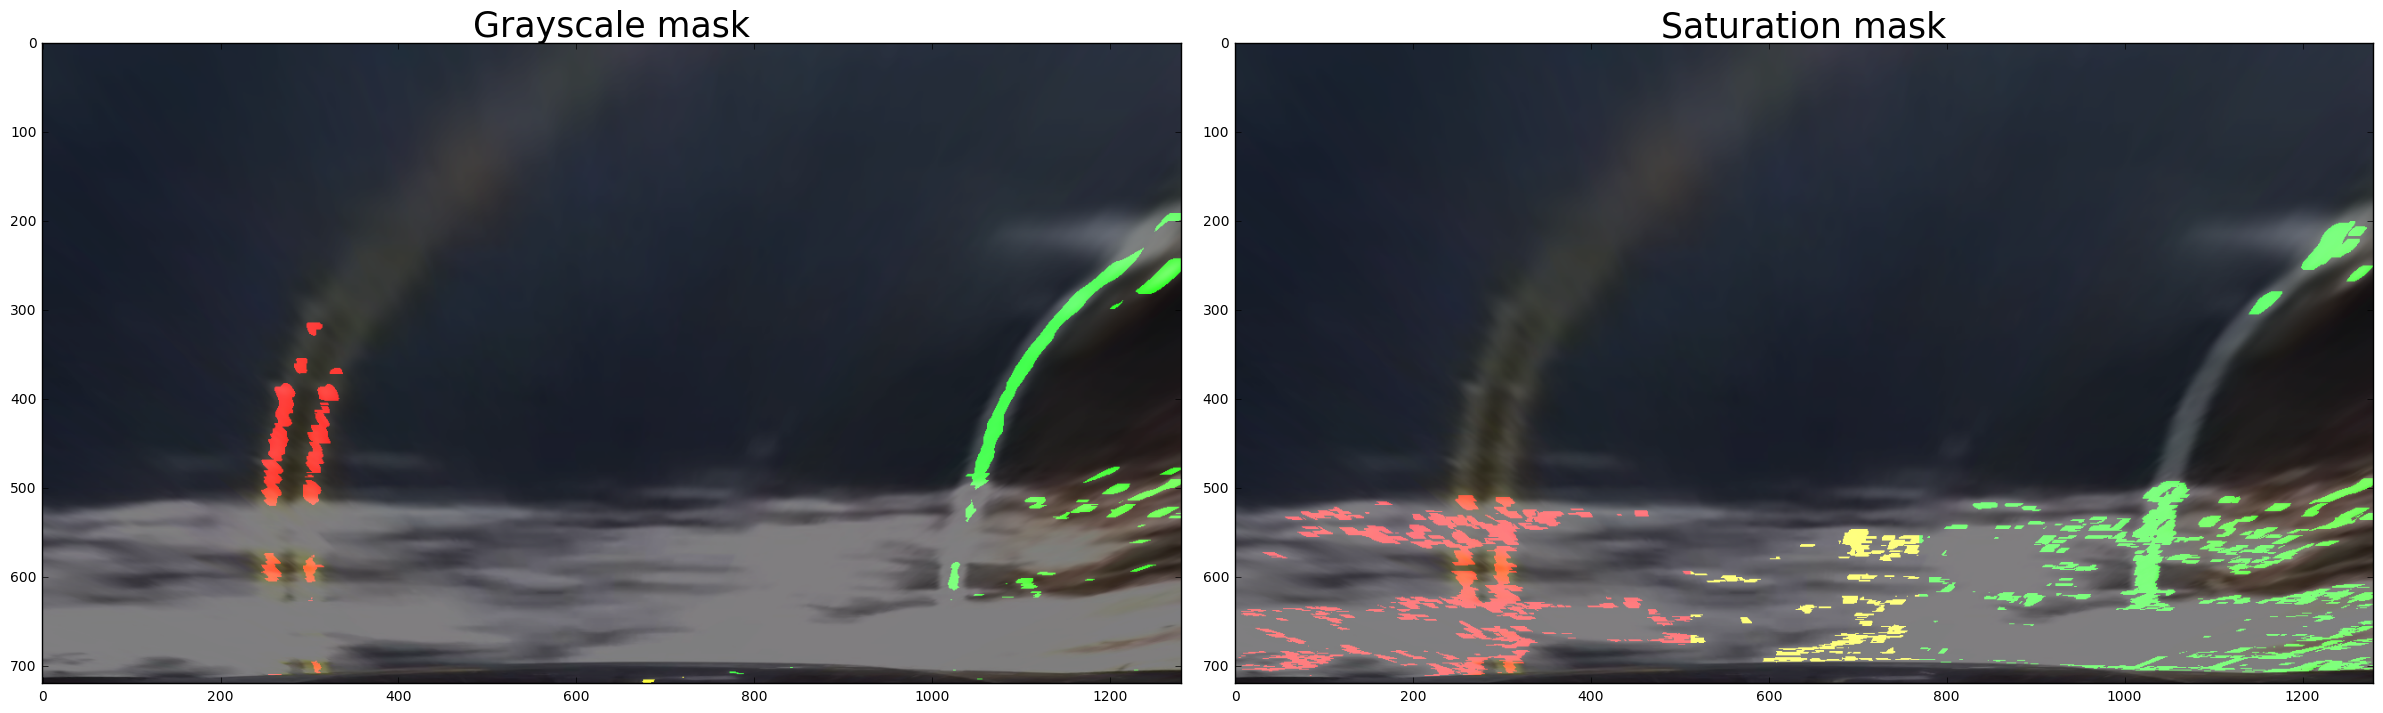

In [14]:
# Compute warped masks...
wimg = cv2.warpPerspective(img, m_perp, img_size, flags=cv2.INTER_LANCZOS4)
wmasks = warped_masks(img, m_perp)

lmask, rmask = default_left_right_masks(img, margin=0.1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
# ax1.imshow(wmasks[0], cmap='gray')
masked_img = draw_mask(wimg, wmasks[0] * lmask, α=0.5, β=1., λ=0., color=[255, 0, 0])
masked_img = draw_mask(masked_img, wmasks[0] * rmask, α=1, β=1., λ=0., color=[0, 255, 0])
ax1.imshow(masked_img)
ax1.set_title('Grayscale mask', fontsize=25)

masked_img = draw_mask(wimg, wmasks[1] * lmask, α=0.5, β=1., λ=0., color=[255, 0, 0])
masked_img = draw_mask(masked_img, wmasks[1] * rmask, α=1, β=1., λ=0., color=[0, 255, 0])
ax2.imshow(masked_img)
ax2.set_title('Saturation mask', fontsize=25)
plt.show()

In [15]:
# unwmask = cv2.warpPerspective(wmasks[0], m_inv_perp, img_size, flags=cv2.INTER_NEAREST)
# X = np.vstack(np.where(unwmask)[::-1]).T
# X = cv2.perspectiveTransform(np.array([X], dtype=np.float32), m_perp)

# print(X.shape)

# # plt.imshow(unwmask > 0.5, cmap='gray')

# plt.scatter(X[0, :, 0], X[0, :, 1], color='yellowgreen', marker='.')
# plt.imshow(wmasks[0], cmap='gray')

In [16]:
wimg = cv2.warpPerspective(img, m_perp, img_size, flags=cv2.INTER_LANCZOS4)
wmasks = warped_masks(img, m_perp)
lmask, rmask = default_left_right_masks(img, margin=0.1)

def fit_ransac(wmasks, add_mask):
    """Fit a Ransac linear regression to masks points.
    """
    x = np.zeros((0,))
    y = np.zeros((0,))
    for wm in wmasks:
        # Perspective trick: construct points in initial space.
        # Avoid giving too much weights to background parts.
#         unwmask = cv2.warpPerspective(wm * add_mask, m_inv_perp, img_size, flags=cv2.INTER_NEAREST)
#         # Back to plane mode!
#         X = np.vstack(np.where(unwmask)[::-1]).T
#         X = cv2.perspectiveTransform(np.array([X], dtype=np.float32), m_perp)
#         if X is not None:
#             x = np.append(x, X[0, :, 1])
#             y = np.append(y, X[0, :, 0])
        x0, y0 = np.where(wm * add_mask)
        x = np.append(x, x0)
        y = np.append(y, y0)
        
    # Construct big vector! Assume order-2 model.
    X = np.zeros((len(x), 3), dtype=np.float32)
    X[:, 0] = 1.
    X[:, 1] = x
    X[:, 2] = x**2
    print(X.shape)

    # Fit regression.
    res_threshold = 15
    max_trials = 1000
    mransac = linear_model.RANSACRegressor(linear_model.LinearRegression(), 
                                           residual_threshold=res_threshold, max_trials=max_trials)
    mransac.fit(X, y)
    
    return mransac, x, y


def warped_lane_mask(wimg, mransac_left, mransac_right):
    """Generate the lane mask based on left and right regression.
    """
    shape = wimg.shape[0:2]
    # Lines predictions.
    X = np.vstack((np.ones(shape[0], ), np.arange(0, shape[0]), np.arange(0, shape[0])**2)).T
    y_left = mransac_left.predict(X)
    y_right = mransac_right.predict(X)

    # Create an image to draw the lines on
    warp_zero = np.zeros(shape, np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([y_left, X[:, 1]]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([y_right, X[:, 1]])))])
    pts = np.hstack((pts_left, pts_right))
    
    
#     pts = [[0, 0],
#            [0, 10], 
#            [10, 10], 
#            [10, 0]]
    pts = np.array([pts], dtype=np.int64)

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, pts, (0,255, 0))
    return color_warp

mransac_left, x_left, y_left = fit_ransac(wmasks, lmask)
mransac_right, x_right, y_right = fit_ransac(wmasks, rmask)

print(mransac_left.estimator_.coef_, mransac_left.estimator_.intercept_)
print(mransac_right.estimator_.coef_)

# Inlier / Outlier masks
inlier_mask_left = mransac_left.inlier_mask_
outlier_mask_left = np.logical_not(inlier_mask_left)
inlier_mask_right = mransac_right.inlier_mask_
outlier_mask_right = np.logical_not(inlier_mask_right)

# New prediction!
line_X_left = np.vstack((np.ones(720, ), np.arange(0, 720), np.arange(0, 720)**2)).T
line_y_left = mransac_left.predict(line_X_left)
line_y_right = mransac_right.predict(line_X_left)

print(mransac_left.predict([0.0, 0.0, 0.0]))

wmask_lane = warped_lane_mask(wimg, mransac_left, mransac_right)

(26094, 3)
(34099, 3)
[  0.00000000e+00  -9.10002476e-01   8.12840517e-04] 509.640056706
[  0.00000000e+00  -1.71983098e+00   1.45422915e-03]
[ 509.64005671]


C:\Users\paulb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


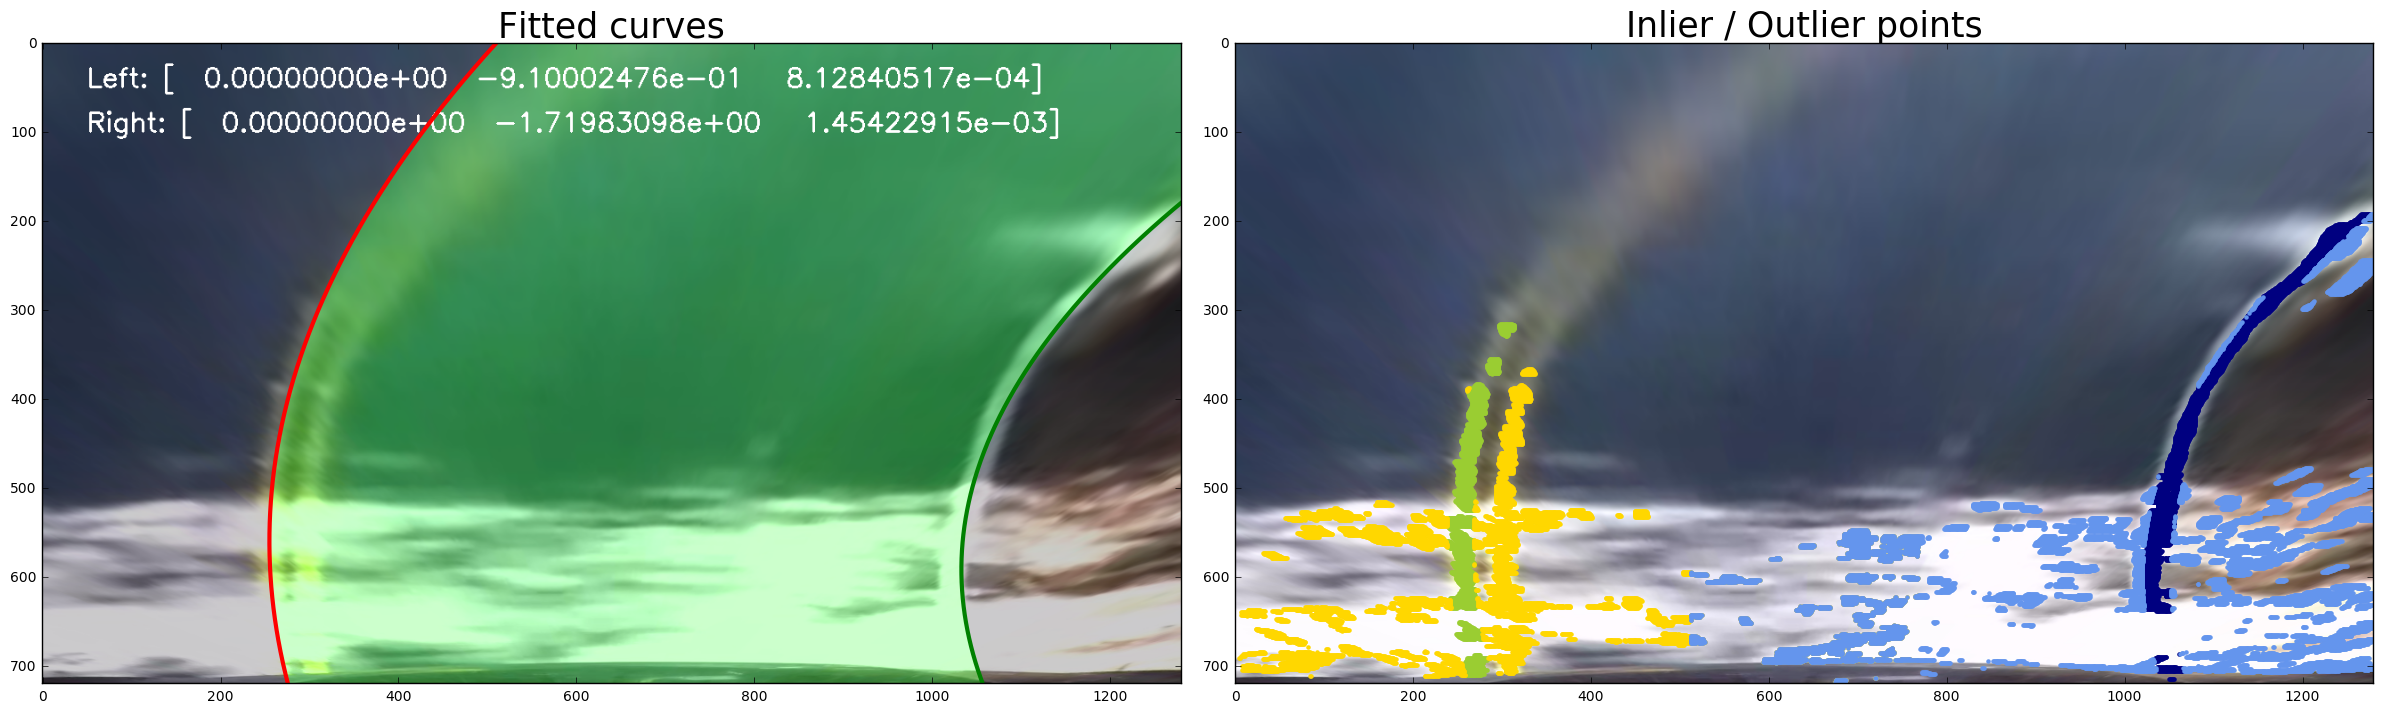

In [17]:
# Plot fitted curves
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.plot(line_y_left, line_X_left[:, 1],  color='red', linestyle='-', linewidth=3)
ax1.plot(line_y_right, line_X_left[:, 1],  color='green', linestyle='-', linewidth=3)

wm_img = cv2.addWeighted(wimg, 0.8, wmask_lane, 0.3, 0.)
cv2.putText(wm_img, "Left: %s" % mransac_left.estimator_.coef_, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
cv2.putText(wm_img, "Right: %s" % mransac_right.estimator_.coef_, (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
ax1.imshow(wm_img)
ax1.set_title('Fitted curves', fontsize=25)

# Scatter points: inlier and outlier.
plt.scatter(y_left[inlier_mask_left], x_left[inlier_mask_left], color='yellowgreen', marker='.')
plt.scatter(y_left[outlier_mask_left], x_left[outlier_mask_left], color='gold', marker='.')
plt.scatter(y_right[inlier_mask_right], x_right[inlier_mask_right], color='navy', marker='.')
plt.scatter(y_right[outlier_mask_right], x_right[outlier_mask_right], color='cornflowerblue', marker='.')
ax2.imshow(wimg)
ax2.set_title('Inlier / Outlier points', fontsize=25)
plt.show()

In [18]:
from lane_ridge import LaneRidge
FLOAT_DTYPES = np.float64

def construct_points(wmasks, add_mask, order=2, reverse_x=True, normalise=True):
    """Construct the collection of points from masks.
    """
    shape = add_mask.shape
    x = np.zeros((0,))
    y = np.zeros((0,))
    for wm in wmasks:
        # Left points.
        x0, y0 = np.where(wm * add_mask)
        x = np.append(x, x0)
        y = np.append(y, y0)   
    # Reverse X axis: zero to bottom of image.
    if reverse_x:
        x = shape[0] - x - 1
    if normalise:
        x = x.astype(FLOAT_DTYPES) / shape[0]
        y = y.astype(FLOAT_DTYPES) / shape[1] - 0.5
        
    # Construct big vector! Assume order-2 model.
    X = np.zeros((len(x), order+1), dtype=FLOAT_DTYPES)
    X[:, 0] = 1.
    for i in range(1, order+1):
        X[:, i] = x**i
    return X.astype(FLOAT_DTYPES), y.astype(FLOAT_DTYPES)


def fit_lanes_ridge(X1, y1, X2, y2, alpha):
    """Fit a special Ridge linear regression to points.
    """
    n_features = X1.shape[1]
    
    # Regularisation parameters.
    max_iter = 1000
    w_reg = np.zeros((2*n_features, ), dtype=FLOAT_DTYPES)
    
    # Fitting model.
    model_lanes=LaneRidge(alpha=alpha, w_reg=w_reg, copy_X=True, max_iter=max_iter, tol=1e-5)
    w0 = np.zeros((2*n_features, ), dtype=FLOAT_DTYPES)
    w0[n_features] = 0.4
    w0[n_features+1] = -0.0001
    w0[n_features+2] = -0.0001
    model_lanes.fit(X1, y1, X2, y2, w0)
    
    return model_lanes

def lanes_predict(model_lanes, wimg, reversed_x=True, normalised=True):
    shape = wimg.shape
    x = np.arange(0, shape[0]).astype(FLOAT_DTYPES)
    if reversed_x:
        x = shape[0] - x - 1
    if normalised:
        x = x / shape[0]
        
    X = np.vstack((np.ones(shape[0], ), x, x**2)).T
    y1, y2 = model_lanes.predict(X, X)
    
    # De-normalise!
    if normalised:
        x = (x) * shape[0]
        X = np.vstack((np.ones(shape[0], ), x, x**2)).T
        y1 = (0.5 + y1) * shape[1]
        y2 = (0.5 + y2) * shape[1]
    if reversed_x:
        x = shape[0] - x - 1
        X = np.vstack((np.ones(shape[0], ), x, x**2)).T
    
    return X, y1, y2
    

X1, y1 = construct_points(wmasks, lmask, order=2, reverse_x=True, normalise=True)
X2, y2 = construct_points(wmasks, rmask, order=2, reverse_x=True, normalise=True)
print(X2.shape)

sub = 1
alpha = np.zeros((6, ), dtype=FLOAT_DTYPES)
alpha[0] = 0.1
alpha[1] = 0.1
alpha[2] = 0.000
alpha[3] = 2.

mlanes = fit_lanes_ridge(X1[::sub,:], y1[::sub], X2[::sub], y2[::sub])

X_lane, y1_lane, y2_lane = lanes_predict(mlanes, wimg, reversed_x=True, normalised=True)


(34099, 3)
Optimization terminated successfully.
         Current function value: 0.039545
         Iterations: 23
         Function evaluations: 200
         Gradient evaluations: 25
[  1.98910305e-02   1.26136277e-02   2.28816314e-01   2.56873537e-01
   7.10808427e-02   7.16800610e-06]
True


[  1.98910305e-02   1.26136277e-02   2.28816314e-01   2.56873537e-01
   7.10808427e-02   7.16800610e-06]
0.443796737311 0.452857739808


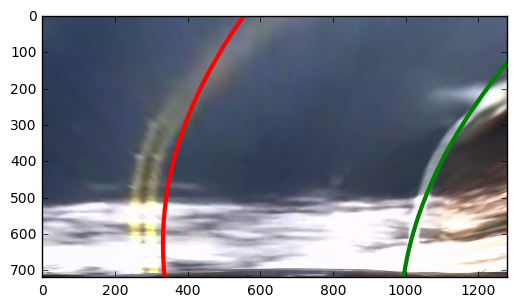

In [19]:
print(mlanes.coef_)
w = mlanes.coef_
w1 = w[:3] - w[3:]
w2 = w[:3] + w[3:]

kappa1 = (2*w1[2]) / ((1 + w1[1])**1.5 + 2*w1[2]*w[3])
kappa2 = (2*w2[2]) / ((1 + w2[1])**1.5 - 2*w2[2]*w[3])
print(kappa1, kappa2)
            

# Plot fitted curves
plt.plot(y1_lane, X_lane[:, 1],  color='red', linestyle='-', linewidth=3)
plt.plot(y2_lane, X_lane[:, 1],  color='green', linestyle='-', linewidth=3)
plt.imshow(wimg)

In [20]:
afds;kjsdf

NameError: name 'afds' is not defined

In [ ]:
# Unwarp everything!
mask_lane = cv2.warpPerspective(wmask_lane, m_inv_perp, img_size, flags=cv2.INTER_NEAREST)
# # Back to plane mode!
# X = np.vstack(np.where(unwmask)[::-1]).T
# X = cv2.perspectiveTransform(np.array([X], dtype=np.float32), m_perp)
        
mask_img = cv2.addWeighted(img, 0.8, mask_lane, 0.3, 0.)
cv2.putText(mask_img, "TEST", (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
plt.imshow(mask_img)

In [ ]:
# Full pipeline on test images.
path = 'test_images/'
# path = 'test_images_kyle/'
path_save = 'debug/'
filenames = os.listdir(path)
for fname in filenames:
    print('Processing image: ', fname)
    img_name = fname[:-4]
    img = load_image(path + fname)
    img_size = (img.shape[1], img.shape[0])
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Warped image.
    wimg = cv2.warpPerspective(img, m_perp, img_size, flags=cv2.INTER_LINEAR)
    wmasks = warped_masks(img, m_perp)
    lmask, rmask = default_left_right_masks(img, margin=0.1)
    
    masked_img = draw_mask(wimg, wmasks[0] * lmask, α=0.5, β=1., λ=0., color=[255, 0, 0])
    masked_img = draw_mask(masked_img, wmasks[0] * rmask, α=1, β=1., λ=0., color=[0, 255, 0])
    mpimg.imsave(path_save+img_name+'_wmask0.jpg', masked_img)
    
    masked_img = draw_mask(wimg, wmasks[1] * lmask, α=0.5, β=1., λ=0., color=[255, 0, 0])
    masked_img = draw_mask(masked_img, wmasks[1] * rmask, α=1, β=1., λ=0., color=[0, 255, 0])
    mpimg.imsave(path_save+img_name+'_wmask1.jpg', masked_img)
    
    
    # Left and right regression.
    mransac_left, x_left, y_left = fit_ransac(wmasks, lmask)
    mransac_right, x_right, y_right = fit_ransac(wmasks, rmask)
    
    # Lane mask
    wmask_lane = warped_lane_mask(wimg, mransac_left, mransac_right)
    wimg_lane = cv2.addWeighted(wimg, 0.8, wmask_lane, 0.3, 0.)
    mask_lane = cv2.warpPerspective(wmask_lane, m_inv_perp, img_size, flags=cv2.INTER_NEAREST)
    img_lane = cv2.addWeighted(img, 0.8, mask_lane, 0.3, 0.)
    
    # Save images.
    mpimg.imsave(path_save+img_name+'_wlane.jpg', wimg_lane)
    mpimg.imsave(path_save+img_name+'_lane.jpg', img_lane)
    


In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import cv2

def process_image(img_orig):
    img_size = (img_orig.shape[1], img_orig.shape[0])
    img = cv2.undistort(img_orig, mtx, dist, None, mtx)
    
    # Warped image.
    wimg = cv2.warpPerspective(img, m_perp, img_size, flags=cv2.INTER_LINEAR)
    wmasks = warped_masks(img, m_perp)
    lmask, rmask = default_left_right_masks(img, margin=0.1)
    
    # Left and right regression.
    mransac_left, x_left, y_left = fit_ransac(wmasks, lmask)
    mransac_right, x_right, y_right = fit_ransac(wmasks, rmask)
    
    # Lane mask
    wmask_lane = warped_lane_mask(wimg, mransac_left, mransac_right)
    mask_lane = cv2.warpPerspective(wmask_lane, m_inv_perp, img_size, flags=cv2.INTER_NEAREST)
    img_lane = cv2.addWeighted(img, 0.8, mask_lane, 0.3, 0.)
    
    return img_lane
    


In [ ]:
white_output = 'project_video_lane.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
white_output = 'challenge_video_lane.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
white_output = 'harder_challenge_video_lane.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)